# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\talga\AppData\Local\Temp\pip-install-l9ibg042\tensorflow-gpu_9310dcd008db41e1926d02cb40bf5c98\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not

In [45]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data

### 2.1 Load Images

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "latin-1") as f:
        label = json.load(f)
    return [label['keypoints']]

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

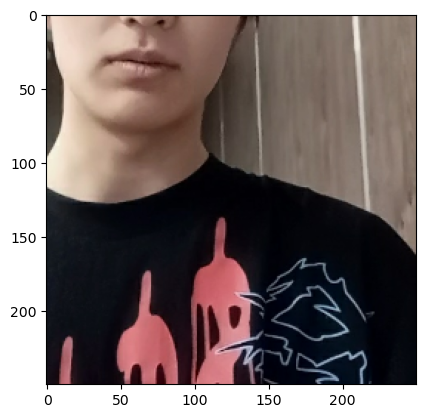

In [13]:
plt.imshow(train_images.as_numpy_iterator().next())

In [14]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [15]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

In [16]:
data_samples = train.as_numpy_iterator()

In [17]:
print(data_samples)

In [18]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


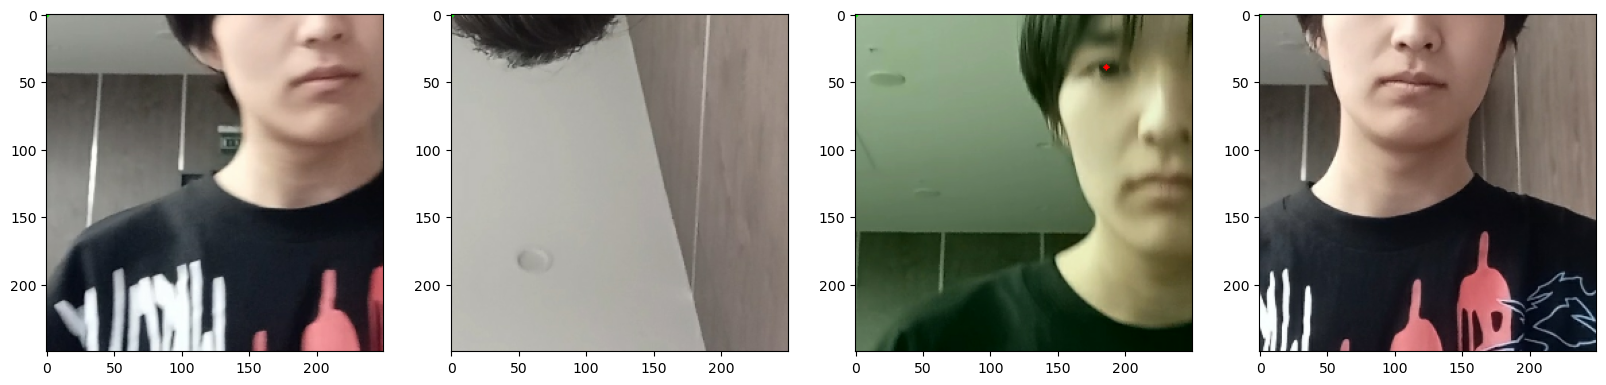

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers.legacy import SGD

In [21]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer

In [23]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [24]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [25]:
X, y = train.as_numpy_iterator().next()

In [26]:
X.shape

(16, 250, 250, 3)

In [27]:
scores = model.predict(X)

1/1 [==============================] - 4s 4s/step


In [28]:
scores

array([[-0.09465525, -0.5658625 ,  0.22789648, -0.7968107 ],
       [ 0.09226862,  0.2943307 ,  0.4974683 ,  0.71655595],
       [-0.07757837,  0.5989535 , -0.26074484, -0.39207926],
       [ 0.200333  , -0.0163621 ,  0.14287929, -0.6851567 ],
       [ 1.2620765 ,  0.6039692 ,  1.424499  , -0.31282836],
       [ 0.15107924,  0.03857236,  0.21615112, -0.5872318 ],
       [ 0.30040595,  0.35855296, -0.06173497, -1.1170356 ],
       [ 0.03798956, -0.07346819,  0.44406205, -0.40562287],
       [-0.2023384 , -0.15895692, -0.31425244, -0.98334783],
       [ 0.5190246 ,  0.2711742 , -0.20892937, -0.84772563],
       [ 0.6167339 ,  0.6217003 ,  0.60754645, -0.7807864 ],
       [ 0.2478126 , -0.2618259 ,  0.5653448 , -0.34474412],
       [-0.49071205,  0.5650245 ,  0.35737282, -1.0058278 ],
       [ 0.07531875,  0.10073102, -0.43809432, -0.5638589 ],
       [ 0.4342265 ,  0.48118168,  1.4191298 , -1.1993947 ],
       [ 0.05955493,  0.5323006 ,  0.46880645, -0.6166553 ]],
      dtype=float32)

### 3.4 Train the Model

In [29]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

923/923 [==============================] - 7865s 9s/step - loss: 0.2304 - val_loss: 0.0564


# 4. Review Performance

### 4.1 View Loss Plots

In [30]:
hist.history

{'loss': [0.23044168949127197], 'val_loss': [0.056386660784482956]}

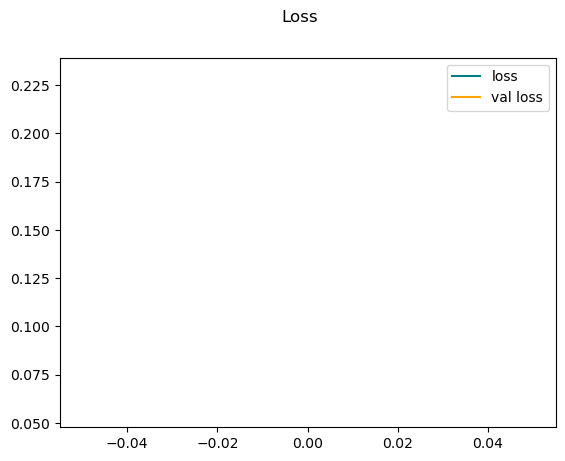

In [31]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

In [32]:
test_data = test.as_numpy_iterator()

In [33]:
test_sample = test_data.next()

In [34]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


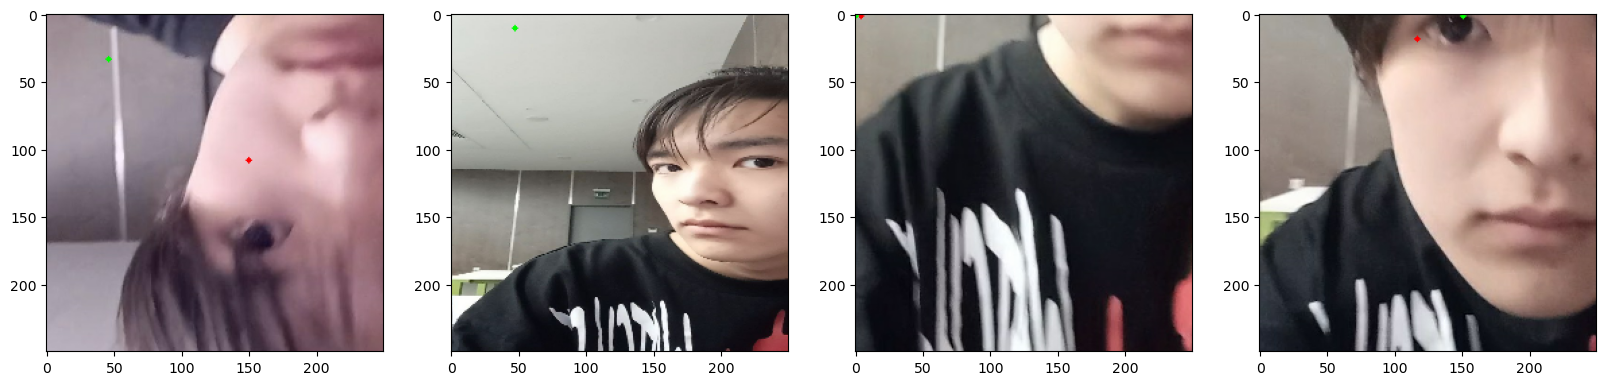

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3. Save the Model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save('eyetrackerresnet.h5')

In [48]:
model = load_model('eyetrackerresnet.h5')

In [49]:
model.predict(test_sample[0])

1/1 [==============================] - 4s 4s/step


array([[ 1.0680306e+01,  8.8775539e+00,  1.1499999e+01,  7.2420335e+00],
       [ 3.1089451e+00,  1.8296860e+00,  2.7310441e+00,  2.8976541e+00],
       [ 1.3152598e+00,  1.1303054e+00,  1.2545156e+00,  1.4620284e+00],
       [ 1.0129957e+01,  2.8517716e+00,  1.0567295e+01,  3.6560326e+00],
       [ 8.6862519e-02,  4.6028301e-02,  5.1696111e-02, -1.1291995e-03],
       [ 6.7616701e-02,  5.6137733e-02,  2.6430581e-02, -9.1204718e-03],
       [ 3.8613451e-01,  3.4510316e-03,  1.9773827e-01,  3.1104827e-02],
       [ 8.9775753e-01,  8.0876899e-01,  3.9428207e-01,  6.2222111e-01],
       [ 1.0992211e+00,  4.8308450e-01,  6.8653598e-02,  8.1687216e-03],
       [ 1.1913010e-01,  3.2842150e-01,  2.6634127e-02,  1.4948010e-01],
       [ 2.9743123e-01,  2.6569796e-01,  4.2373699e-01,  2.7192485e-01],
       [ 3.3584017e-01,  5.6088847e-01,  4.9925530e-01,  5.7382351e-01],
       [ 2.7212340e-02,  1.4236877e-03,  7.7251922e-03,  1.1581911e-03],
       [ 2.8202131e-02,  5.9313970e-03, -3.4806516e

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    print(cap.read())
    _ , frame = cap.read()
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

(True, array([[[116, 123, 122],
        [112, 119, 120],
        [114, 120, 122],
        ...,
        [132, 133, 121],
        [129, 130, 116],
        [129, 130, 116]],

       [[114, 121, 119],
        [114, 120, 120],
        [115, 121, 122],
        ...,
        [131, 132, 120],
        [130, 131, 118],
        [127, 129, 115]],

       [[112, 120, 117],
        [116, 123, 121],
        [116, 123, 121],
        ...,
        [130, 132, 120],
        [130, 132, 120],
        [127, 130, 117]],

       ...,

       [[151, 154, 147],
        [150, 153, 146],
        [150, 153, 146],
        ...,
        [173, 176, 164],
        [175, 177, 165],
        [172, 175, 163]],

       [[151, 153, 145],
        [153, 156, 148],
        [153, 155, 148],
        ...,
        [175, 178, 164],
        [175, 178, 164],
        [171, 174, 161]],

       [[153, 155, 145],
        [154, 156, 147],
        [155, 156, 149],
        ...,
        [173, 177, 163],
        [172, 175, 161],
        [170, 173

1/1 [==============================] - 0s 373ms/step
(True, array([[[122, 118, 127],
        [121, 119, 124],
        [121, 121, 121],
        ...,
        [140, 131, 130],
        [140, 131, 131],
        [139, 129, 130]],

       [[123, 118, 126],
        [121, 119, 123],
        [123, 122, 122],
        ...,
        [140, 133, 130],
        [139, 131, 130],
        [137, 129, 128]],

       [[126, 121, 125],
        [123, 119, 121],
        [120, 119, 119],
        ...,
        [139, 135, 129],
        [136, 131, 126],
        [138, 133, 129]],

       ...,

       [[150, 153, 151],
        [152, 154, 152],
        [154, 157, 154],
        ...,
        [171, 173, 166],
        [176, 177, 170],
        [171, 173, 166]],

       [[149, 152, 150],
        [153, 156, 153],
        [154, 157, 154],
        ...,
        [173, 175, 168],
        [172, 174, 167],
        [170, 172, 165]],

       [[149, 152, 150],
        [152, 154, 152],
        [153, 156, 153],
        ...,
        [172, 

1/1 [==============================] - 0s 360ms/step
(True, array([[[122, 121, 115],
        [124, 123, 118],
        [124, 123, 119],
        ...,
        [136, 133, 125],
        [136, 133, 126],
        [133, 130, 124]],

       [[121, 122, 114],
        [123, 122, 116],
        [120, 120, 115],
        ...,
        [135, 133, 125],
        [134, 132, 125],
        [134, 132, 125]],

       [[119, 121, 111],
        [119, 121, 112],
        [117, 118, 112],
        ...,
        [133, 132, 123],
        [134, 133, 125],
        [135, 134, 126]],

       ...,

       [[154, 155, 150],
        [154, 155, 150],
        [154, 155, 150],
        ...,
        [172, 174, 167],
        [173, 175, 168],
        [172, 174, 167]],

       [[154, 155, 150],
        [155, 156, 151],
        [155, 156, 150],
        ...,
        [173, 175, 168],
        [173, 175, 168],
        [172, 174, 167]],

       [[154, 155, 150],
        [156, 157, 152],
        [157, 159, 152],
        ...,
        [173, 

1/1 [==============================] - 0s 360ms/step
(True, array([[[125, 131, 137],
        [124, 129, 137],
        [123, 128, 136],
        ...,
        [149, 145, 141],
        [149, 145, 141],
        [150, 146, 142]],

       [[126, 131, 136],
        [125, 129, 136],
        [123, 128, 135],
        ...,
        [147, 144, 139],
        [147, 144, 139],
        [149, 146, 141]],

       [[126, 130, 134],
        [127, 131, 136],
        [124, 128, 134],
        ...,
        [145, 143, 137],
        [146, 144, 138],
        [148, 147, 141]],

       ...,

       [[ 31,  36,  32],
        [ 30,  35,  31],
        [ 33,  39,  34],
        ...,
        [185, 186, 173],
        [184, 184, 173],
        [183, 183, 171]],

       [[ 32,  37,  34],
        [ 31,  36,  33],
        [ 31,  36,  33],
        ...,
        [187, 188, 175],
        [184, 184, 173],
        [183, 183, 171]],

       [[ 33,  38,  35],
        [ 31,  36,  33],
        [ 30,  35,  32],
        ...,
        [186, 

1/1 [==============================] - 0s 376ms/step
(True, array([[[120, 121, 128],
        [121, 121, 128],
        [122, 121, 128],
        ...,
        [142, 138, 133],
        [140, 137, 133],
        [139, 136, 131]],

       [[121, 122, 127],
        [122, 122, 128],
        [122, 122, 128],
        ...,
        [138, 136, 130],
        [139, 137, 132],
        [138, 136, 131]],

       [[124, 128, 129],
        [122, 125, 128],
        [121, 124, 127],
        ...,
        [148, 148, 141],
        [140, 140, 134],
        [138, 139, 132]],

       ...,

       [[146, 152, 152],
        [145, 146, 146],
        [122, 118, 119],
        ...,
        [179, 184, 174],
        [180, 186, 174],
        [178, 183, 172]],

       [[150, 155, 151],
        [149, 150, 146],
        [146, 144, 140],
        ...,
        [176, 182, 172],
        [178, 184, 174],
        [176, 182, 172]],

       [[153, 156, 151],
        [150, 152, 146],
        [143, 142, 135],
        ...,
        [173, 

1/1 [==============================] - 0s 361ms/step
(True, array([[[126, 127, 120],
        [127, 128, 122],
        [128, 130, 123],
        ...,
        [143, 146, 122],
        [145, 149, 122],
        [138, 142, 115]],

       [[126, 127, 120],
        [127, 128, 122],
        [129, 131, 124],
        ...,
        [144, 147, 124],
        [143, 147, 121],
        [138, 142, 116]],

       [[127, 128, 122],
        [126, 127, 120],
        [127, 128, 122],
        ...,
        [142, 144, 124],
        [141, 143, 121],
        [139, 142, 120]],

       ...,

       [[160, 164, 160],
        [160, 164, 160],
        [159, 163, 159],
        ...,
        [ 88, 110, 130],
        [ 89, 111, 129],
        [ 89, 111, 129]],

       [[158, 163, 157],
        [158, 163, 158],
        [158, 163, 159],
        ...,
        [ 87, 109, 128],
        [ 87, 109, 128],
        [ 87, 109, 128]],

       [[156, 163, 155],
        [158, 163, 157],
        [160, 166, 160],
        ...,
        [ 84, 

1/1 [==============================] - 0s 365ms/step
(True, array([[[129, 130, 114],
        [127, 131, 118],
        [124, 131, 121],
        ...,
        [155, 146, 135],
        [155, 146, 135],
        [155, 146, 135]],

       [[129, 130, 115],
        [127, 131, 118],
        [122, 128, 118],
        ...,
        [154, 146, 136],
        [154, 146, 136],
        [154, 146, 136]],

       [[126, 127, 112],
        [124, 128, 115],
        [122, 127, 116],
        ...,
        [153, 145, 137],
        [152, 145, 136],
        [152, 145, 136]],

       ...,

       [[162, 161, 155],
        [161, 159, 153],
        [163, 162, 155],
        ...,
        [ 59,  74,  81],
        [ 57,  73,  80],
        [ 67,  82,  89]],

       [[163, 160, 155],
        [164, 162, 156],
        [165, 163, 156],
        ...,
        [ 62,  75,  82],
        [ 60,  73,  79],
        [ 64,  78,  84]],

       [[166, 162, 158],
        [166, 163, 157],
        [166, 163, 156],
        ...,
        [ 63, 

1/1 [==============================] - 0s 355ms/step
(True, array([[[127, 125, 132],
        [127, 126, 129],
        [129, 130, 127],
        ...,
        [148, 146, 132],
        [147, 146, 132],
        [146, 145, 131]],

       [[126, 124, 130],
        [126, 125, 128],
        [127, 127, 126],
        ...,
        [148, 146, 133],
        [146, 145, 132],
        [145, 144, 130]],

       [[128, 127, 131],
        [127, 126, 129],
        [123, 123, 124],
        ...,
        [146, 146, 134],
        [143, 143, 131],
        [142, 142, 130]],

       ...,

       [[161, 162, 162],
        [164, 164, 164],
        [164, 164, 164],
        ...,
        [181, 184, 178],
        [180, 182, 175],
        [180, 182, 175]],

       [[160, 161, 163],
        [160, 162, 162],
        [159, 161, 161],
        ...,
        [180, 184, 175],
        [180, 184, 174],
        [178, 182, 172]],

       [[157, 159, 161],
        [157, 159, 160],
        [157, 160, 159],
        ...,
        [179, 

1/1 [==============================] - 0s 361ms/step
(True, array([[[144, 137, 120],
        [147, 140, 125],
        [148, 142, 129],
        ...,
        [155, 153, 151],
        [156, 151, 150],
        [156, 151, 150]],

       [[142, 136, 118],
        [144, 139, 124],
        [147, 142, 129],
        ...,
        [155, 153, 150],
        [156, 153, 151],
        [156, 153, 151]],

       [[140, 137, 120],
        [142, 139, 124],
        [144, 141, 128],
        ...,
        [155, 153, 150],
        [155, 153, 151],
        [157, 155, 153]],

       ...,

       [[170, 174, 169],
        [171, 175, 170],
        [170, 174, 169],
        ...,
        [186, 190, 185],
        [186, 190, 185],
        [189, 192, 187]],

       [[170, 174, 169],
        [169, 172, 167],
        [169, 172, 167],
        ...,
        [188, 191, 185],
        [186, 190, 184],
        [186, 190, 184]],

       [[170, 174, 169],
        [168, 171, 166],
        [167, 170, 165],
        ...,
        [188, 

1/1 [==============================] - 0s 376ms/step
(True, array([[[124, 125, 112],
        [127, 128, 113],
        [127, 128, 112],
        ...,
        [137, 139, 122],
        [137, 139, 122],
        [137, 139, 122]],

       [[123, 124, 111],
        [126, 127, 112],
        [128, 129, 113],
        ...,
        [139, 140, 124],
        [137, 139, 122],
        [136, 137, 121]],

       [[121, 121, 109],
        [126, 126, 112],
        [124, 126, 110],
        ...,
        [139, 140, 124],
        [138, 140, 124],
        [136, 137, 121]],

       ...,

       [[159, 160, 156],
        [159, 160, 156],
        [158, 159, 155],
        ...,
        [178, 179, 174],
        [177, 178, 173],
        [177, 178, 173]],

       [[157, 158, 154],
        [155, 156, 151],
        [156, 157, 152],
        ...,
        [179, 180, 175],
        [178, 179, 174],
        [177, 178, 173]],

       [[155, 156, 151],
        [154, 155, 150],
        [155, 156, 151],
        ...,
        [179, 

1/1 [==============================] - 0s 358ms/step
(True, array([[[113, 121,  97],
        [115, 123, 101],
        [118, 124, 106],
        ...,
        [133, 132, 129],
        [131, 130, 126],
        [130, 129, 124]],

       [[113, 120,  99],
        [114, 121, 101],
        [115, 122, 104],
        ...,
        [135, 135, 131],
        [133, 132, 128],
        [132, 131, 127]],

       [[113, 121, 103],
        [112, 120, 102],
        [112, 119, 102],
        ...,
        [134, 135, 131],
        [133, 134, 129],
        [133, 134, 129]],

       ...,

       [[148, 148, 142],
        [146, 147, 140],
        [148, 150, 142],
        ...,
        [173, 174, 165],
        [176, 178, 169],
        [173, 174, 165]],

       [[148, 149, 145],
        [147, 148, 144],
        [147, 148, 144],
        ...,
        [176, 177, 167],
        [177, 178, 169],
        [175, 175, 166]],

       [[151, 152, 150],
        [150, 151, 148],
        [148, 148, 146],
        ...,
        [176, 

1/1 [==============================] - 0s 354ms/step
(True, array([[[119, 126, 107],
        [121, 127, 108],
        [122, 127, 108],
        ...,
        [141, 137, 133],
        [143, 137, 133],
        [144, 138, 134]],

       [[121, 128, 110],
        [123, 129, 111],
        [123, 128, 110],
        ...,
        [140, 137, 132],
        [141, 137, 132],
        [144, 139, 134]],

       [[122, 130, 113],
        [122, 129, 112],
        [123, 128, 112],
        ...,
        [141, 140, 134],
        [142, 140, 134],
        [143, 141, 135]],

       ...,

       [[ 24,  23,  14],
        [ 26,  25,  17],
        [ 29,  27,  19],
        ...,
        [177, 181, 174],
        [178, 182, 175],
        [177, 181, 174]],

       [[ 23,  24,  16],
        [ 27,  27,  20],
        [ 29,  29,  23],
        ...,
        [177, 181, 174],
        [179, 183, 176],
        [178, 182, 175]],

       [[ 24,  26,  19],
        [ 27,  28,  22],
        [ 28,  29,  24],
        ...,
        [179, 

1/1 [==============================] - 0s 376ms/step
(True, array([[[125, 116, 115],
        [126, 117, 117],
        [124, 114, 115],
        ...,
        [132, 126, 127],
        [132, 128, 128],
        [136, 131, 131]],

       [[124, 116, 114],
        [124, 116, 115],
        [120, 112, 112],
        ...,
        [131, 127, 126],
        [131, 128, 128],
        [135, 131, 131]],

       [[124, 119, 116],
        [122, 117, 114],
        [118, 113, 112],
        ...,
        [129, 128, 127],
        [131, 131, 129],
        [137, 136, 135]],

       ...,

       [[ 39,  32,  26],
        [ 39,  32,  27],
        [ 44,  38,  33],
        ...,
        [170, 174, 167],
        [170, 174, 167],
        [171, 175, 168]],

       [[ 42,  36,  30],
        [ 43,  37,  31],
        [ 46,  40,  35],
        ...,
        [170, 174, 168],
        [170, 174, 168],
        [170, 174, 168]],

       [[ 42,  37,  31],
        [ 42,  37,  31],
        [ 45,  39,  33],
        ...,
        [169, 